In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from python_splitters import python_chrono_split

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [2]:
df = pd.read_csv('./filter_data_new.csv', dtype={'hospital_pk':str, 'state':str}, parse_dates=['collection_week'])
df.drop(columns=["hospital_subtype"], inplace=True)

In [3]:
state_data_vals = df.groupby(["state", "collection_week"], as_index=False)[df.columns[6:]].sum()
state_data_vals.head()

,state,collection_week,total_beds_7_day_avg,inpatient_beds_used_covid_7_day_avg,total_beds_7_day_sum,all_adult_hospital_beds_7_day_sum,all_adult_hospital_inpatient_beds_7_day_sum,inpatient_beds_used_covid_7_day_sum,total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum,total_adult_patients_hospitalized_confirmed_covid_7_day_sum,inpatient_beds_7_day_sum,total_icu_beds_7_day_sum,total_staffed_adult_icu_beds_7_day_sum,icu_beds_used_7_day_sum,staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_sum,staffed_icu_adult_patients_confirmed_covid_7_day_sum,previous_day_covid_ED_visits_7_day_sum,previous_day_admission_adult_covid_suspected_7_day_sum,all_pediatric_inpatient_bed_occupied_7_day_avg
0,AK,2020-03-20,81.0,0.0,324,0,0,9,0,0,224,36,0,0,0,0,0,0,0.0
1,AK,2020-03-27,1353.0,0.0,1783,0,0,13,0,0,1397,181,0,0,0,0,0,0,0.0
2,AK,2020-04-03,1405.0,15.0,9304,0,0,24,0,0,7248,931,0,0,0,0,0,0,0.0
3,AK,2020-04-10,1457.4,12.8,8667,0,0,56,0,0,6965,1153,0,0,0,0,0,0,0.0
4,AK,2020-04-17,1374.7,27.0,7031,0,0,163,0,0,6041,1436,0,0,0,0,0,0,0.0


In [4]:
metro_data_vals = df.groupby(["is_metro_micro", "collection_week"], as_index=False)[df.columns[6:]].sum()
metro_data_vals.head()

,is_metro_micro,collection_week,total_beds_7_day_avg,inpatient_beds_used_covid_7_day_avg,total_beds_7_day_sum,all_adult_hospital_beds_7_day_sum,all_adult_hospital_inpatient_beds_7_day_sum,inpatient_beds_used_covid_7_day_sum,total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum,total_adult_patients_hospitalized_confirmed_covid_7_day_sum,inpatient_beds_7_day_sum,total_icu_beds_7_day_sum,total_staffed_adult_icu_beds_7_day_sum,icu_beds_used_7_day_sum,staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_sum,staffed_icu_adult_patients_confirmed_covid_7_day_sum,previous_day_covid_ED_visits_7_day_sum,previous_day_admission_adult_covid_suspected_7_day_sum,all_pediatric_inpatient_bed_occupied_7_day_avg
0,False,2019-12-27,75.0,0.0,75,70,57,0,0,0,62,0,0,0,0,0,0,0,0.0
1,False,2020-01-31,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
2,False,2020-02-07,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
3,False,2020-02-14,55.0,0.0,87,0,0,0,0,0,73,4,0,0,0,0,0,0,0.0
4,False,2020-02-21,16.0,0.0,32,0,0,0,0,0,32,0,0,0,0,0,0,0,0.0


In [5]:
NUM_NON_NUMERIC = 2

In [6]:
INPUT_WIDTH = 7 # use 7 weeks of data to train
OFFSET_WIDTH = 12 # we want to predict 12 weeks out
LABEL_WIDTH = 1 # we want the last week after offset as our model's output

WINDOW_SIZE = INPUT_WIDTH+OFFSET_WIDTH

In [7]:
val_performance = {}
performance = {}

# EDA

In [8]:
min_ts = df['collection_week'].min()
max_ts = df['collection_week'].max()
min_ts, max_ts

(Timestamp('2019-12-27 00:00:00'), Timestamp('2023-02-10 00:00:00'))

In [9]:
collection_dates = pd.date_range(min_ts, max_ts, freq='7D')
collection_dates.shape

(164,)

In [10]:
df[['hospital_pk', 'collection_week']].groupby('hospital_pk').agg(min)['collection_week'].max(), df[['hospital_pk', 'collection_week']].groupby('hospital_pk').agg(max)['collection_week'].min()

(Timestamp('2023-01-27 00:00:00'), Timestamp('2020-03-27 00:00:00'))

In [11]:
df.shape

(742253, 23)

In [12]:
len(df['hospital_pk'].unique())

5144

In [13]:
# OHE
# df['hospital_subtype'].unique()

## Interpolate data for each hospitals' missing dates
linear interpolation and filling in non-numeric data

In [14]:
# df = pd.get_dummies(df, columns=['hospital_subtype'])

In [15]:
df.head(3)

,hospital_pk,collection_week,state,city,fips_code,is_metro_micro,total_beds_7_day_avg,inpatient_beds_used_covid_7_day_avg,total_beds_7_day_sum,all_adult_hospital_beds_7_day_sum,...,total_adult_patients_hospitalized_confirmed_covid_7_day_sum,inpatient_beds_7_day_sum,total_icu_beds_7_day_sum,total_staffed_adult_icu_beds_7_day_sum,icu_beds_used_7_day_sum,staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_sum,staffed_icu_adult_patients_confirmed_covid_7_day_sum,previous_day_covid_ED_visits_7_day_sum,previous_day_admission_adult_covid_suspected_7_day_sum,all_pediatric_inpatient_bed_occupied_7_day_avg
0,10001,2020-03-27,AL,DOTHAN,1069,True,458.4,29.4,3209,0,...,0,2630,290,0,0,0,0,0,0,0.0
1,10001,2020-04-03,AL,DOTHAN,1069,True,459.0,45.9,3213,0,...,0,2632,306,0,0,0,0,0,0,0.0
2,10001,2020-04-10,AL,DOTHAN,1069,True,458.7,48.0,3211,0,...,0,2632,342,0,0,0,0,0,0,0.0


In [16]:
# all_dates_df = None

# # ffill/bfill cols [:9], lin interp cols: [9:]

# for pk, hosp_df in df.groupby('state', sort=False):
#     hosp_df = hosp_df.copy()
#     min_ts = hosp_df['collection_week'].min()
#     max_ts = hosp_df['collection_week'].max()
#     date_ser = pd.Series(pd.date_range(min_ts, max_ts, freq='7D'), name = 'collection_week')

#     if hosp_df.shape[0] != date_ser.shape[0]:
#         hosp_df = hosp_df.merge(date_ser, on='collection_week', how='right')
#         hosp_df.iloc[:, :NUM_NON_NUMERIC] = hosp_df.iloc[:, :NUM_NON_NUMERIC].fillna(method='ffill')
#         hosp_df.iloc[:, :NUM_NON_NUMERIC] = hosp_df.iloc[:, :NUM_NON_NUMERIC].fillna(method='bfill')
#         hosp_df.iloc[:, NUM_NON_NUMERIC:] = hosp_df.iloc[:, NUM_NON_NUMERIC:].interpolate()

#     all_dates_df = pd.concat((all_dates_df, hosp_df))
# all_dates_df.shape

In [17]:
del df

In [18]:
# ctr = 0
# hosp_pk_to_ID = {}
# ID_to_hosp_pk = {}

# for h_pk in all_dates_df['hospital_pk']:
#     if h_pk not in hosp_pk_to_ID:
#         hosp_pk_to_ID[h_pk] = ctr
#         ID_to_hosp_pk[ctr] = h_pk
#         ctr += 1

# all_dates_df['hospital_pk_ID'] = all_dates_df['hospital_pk'].apply(lambda x : hosp_pk_to_ID[x])

In [19]:
# all_dates_df.head(2)
state_data_vals.head(2)

,state,collection_week,total_beds_7_day_avg,inpatient_beds_used_covid_7_day_avg,total_beds_7_day_sum,all_adult_hospital_beds_7_day_sum,all_adult_hospital_inpatient_beds_7_day_sum,inpatient_beds_used_covid_7_day_sum,total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum,total_adult_patients_hospitalized_confirmed_covid_7_day_sum,inpatient_beds_7_day_sum,total_icu_beds_7_day_sum,total_staffed_adult_icu_beds_7_day_sum,icu_beds_used_7_day_sum,staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_sum,staffed_icu_adult_patients_confirmed_covid_7_day_sum,previous_day_covid_ED_visits_7_day_sum,previous_day_admission_adult_covid_suspected_7_day_sum,all_pediatric_inpatient_bed_occupied_7_day_avg
0,AK,2020-03-20,81.0,0.0,324,0,0,9,0,0,224,36,0,0,0,0,0,0,0.0
1,AK,2020-03-27,1353.0,0.0,1783,0,0,13,0,0,1397,181,0,0,0,0,0,0,0.0


In [20]:
# all_dates_df['is_metro_micro'].fillna(0, inplace=True)

In [21]:
type_map = {col_name : np.float32 for i, col_name in enumerate(state_data_vals.columns) if i > NUM_NON_NUMERIC and col_name != 'state'}
# type_map['hospital_pk_ID'] = np.int16
# type_map['is_metro_micro'] = np.float32
all_dates_df = state_data_vals.astype(type_map)

### Train-Test-Val Split

for each hospital/state/etc take 70% of the data for train, test, val

In [22]:
# use MS Recommender code to T/T/V split for each hospital
train_df, test_df, val_df = python_chrono_split(state_data_vals, [0.7,0.2,0.1], 1, 'user', 'state', 'inpatient_beds_used_covid_7_day_sum', 'collection_week')

In [23]:
test_df.head(5)

,state,collection_week,total_beds_7_day_avg,inpatient_beds_used_covid_7_day_avg,total_beds_7_day_sum,all_adult_hospital_beds_7_day_sum,all_adult_hospital_inpatient_beds_7_day_sum,inpatient_beds_used_covid_7_day_sum,total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum,total_adult_patients_hospitalized_confirmed_covid_7_day_sum,inpatient_beds_7_day_sum,total_icu_beds_7_day_sum,total_staffed_adult_icu_beds_7_day_sum,icu_beds_used_7_day_sum,staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_sum,staffed_icu_adult_patients_confirmed_covid_7_day_sum,previous_day_covid_ED_visits_7_day_sum,previous_day_admission_adult_covid_suspected_7_day_sum,all_pediatric_inpatient_bed_occupied_7_day_avg
106,AK,2022-04-01,902.9,7.1,6320,5264,8092,141,130,125,9388,1565,872,1330,35,33,371,4,29.7
107,AK,2022-04-08,906.0,10.9,6369,5207,8047,130,109,109,9447,1626,884,1385,30,30,419,0,39.1
108,AK,2022-04-15,880.3,6.9,6185,5127,7976,98,87,85,9272,1483,840,1209,32,32,395,0,36.9
109,AK,2022-04-22,945.9,10.3,6459,5420,8108,137,136,134,9385,1567,865,1311,29,29,431,0,28.3
110,AK,2022-04-29,965.0,17.4,6755,5597,8007,194,176,172,9459,1705,907,1391,34,34,474,0,41.6


In [24]:
train_df_num = train_df.iloc[:, NUM_NON_NUMERIC:].copy()
test_df_num = test_df.iloc[:, NUM_NON_NUMERIC:].copy()
val_df_num = val_df.iloc[:, NUM_NON_NUMERIC:].copy()

### Normalize Data

In [25]:
train_mean = train_df_num.iloc[:, :-1].mean()
train_std = train_df_num.iloc[:, :-1].std()

train_df_num.iloc[:, :-1] = (train_df_num.iloc[:, :-1] - train_mean) / train_std
test_df_num.iloc[:, :-1]  = (test_df_num.iloc[:, :-1]  - train_mean) / train_std
val_df_num.iloc[:, :-1]  = (val_df_num.iloc[:, :-1]  - train_mean) / train_std

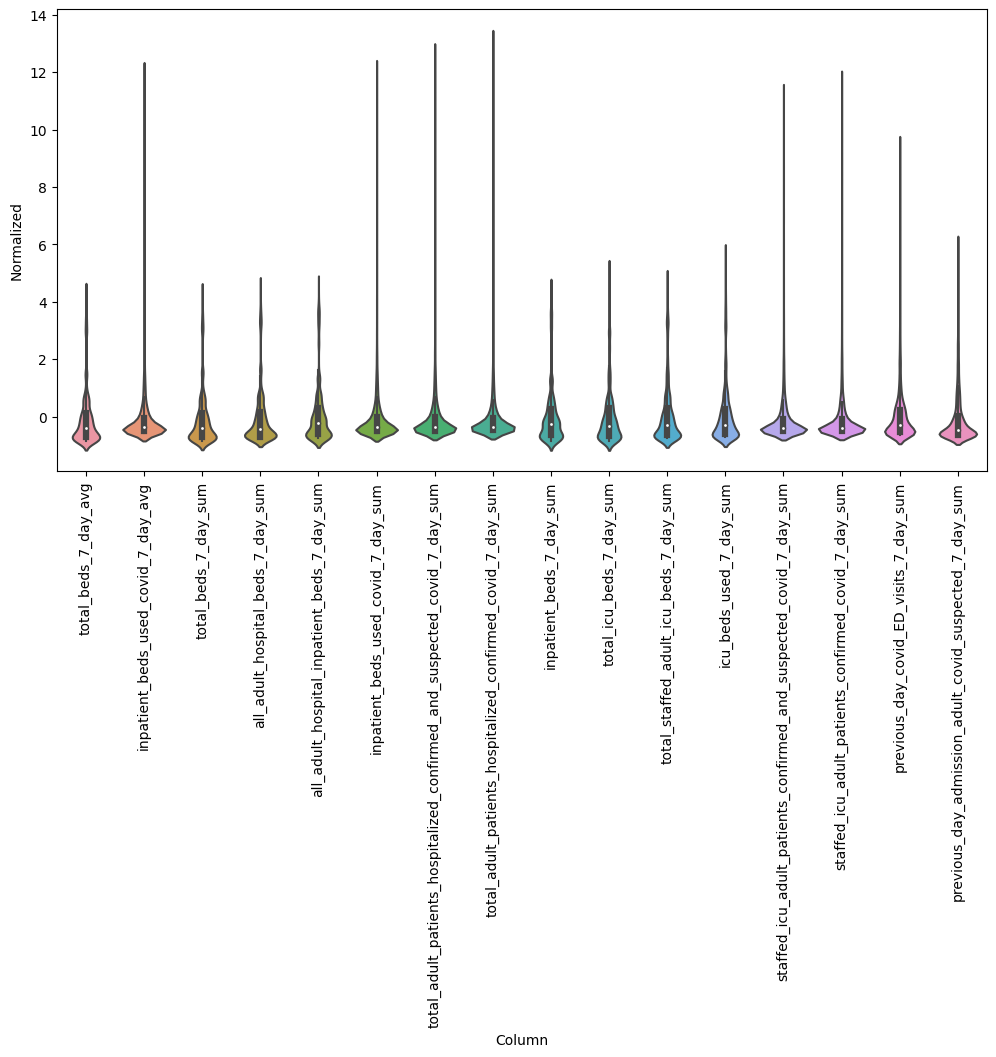

In [26]:
df_std = (all_dates_df.iloc[:, NUM_NON_NUMERIC:-1] - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(all_dates_df.iloc[:, NUM_NON_NUMERIC:-1].columns, rotation=90)

Window:
[   7 weeks train   |   11 wk offset    |   1 label wk  ]
len(window) = 7+11+1 = 19

In [27]:
# Citation: Google https://www.tensorflow.org/tutorials/structured_data/time_series#data_windowing
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
          self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)
        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        return inputs, labels

    def plot(self, model=None, plot_col='inpatient_beds_used_covid_7_day_sum', max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)
            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index
            if label_col_index is None:
              continue
            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, -len(self.label_indices):, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='#ff7f0e', s=64)
            if n == 0:
              plt.legend()
        plt.xlabel('Time [W]')

    def make_dataset(self, data):
      data = np.array(data, dtype=np.float32)
      ds = tf.keras.utils.timeseries_dataset_from_array(
          data=data,
          targets=None,
          sequence_length=self.total_window_size,
          sequence_stride=1,
          shuffle=True,
          batch_size=32,)

      ds = ds.map(self.split_window)
      return ds

    @property
    def train(self):
      return self.make_dataset(self.train_df)

    @property
    def val(self):
      return self.make_dataset(self.val_df)

    @property
    def test(self):
      return self.make_dataset(self.test_df)

    @property
    def example(self):
      """Get and cache an example batch of `inputs, labels` for plotting."""
      result = getattr(self, '_example', None)
      if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
      return result

In [28]:
w1 = WindowGenerator(input_width=8, label_width=1, shift=12,
                     train_df=train_df_num, test_df=test_df_num, val_df=val_df_num,
                     label_columns=['inpatient_beds_used_covid_7_day_sum'])
w1

Total window size: 20
Input indices: [0 1 2 3 4 5 6 7]
Label indices: [19]
Label column name(s): ['inpatient_beds_used_covid_7_day_sum']

In [29]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(test_df_num.iloc[:w1.total_window_size]),
                           np.array(test_df_num.iloc[2:2+w1.total_window_size]),
                           np.array(test_df_num.iloc[4:4+w1.total_window_size])])

example_inputs, example_labels = w1.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 20, 17)
Inputs shape: (3, 8, 17)
Labels shape: (3, 1, 1)


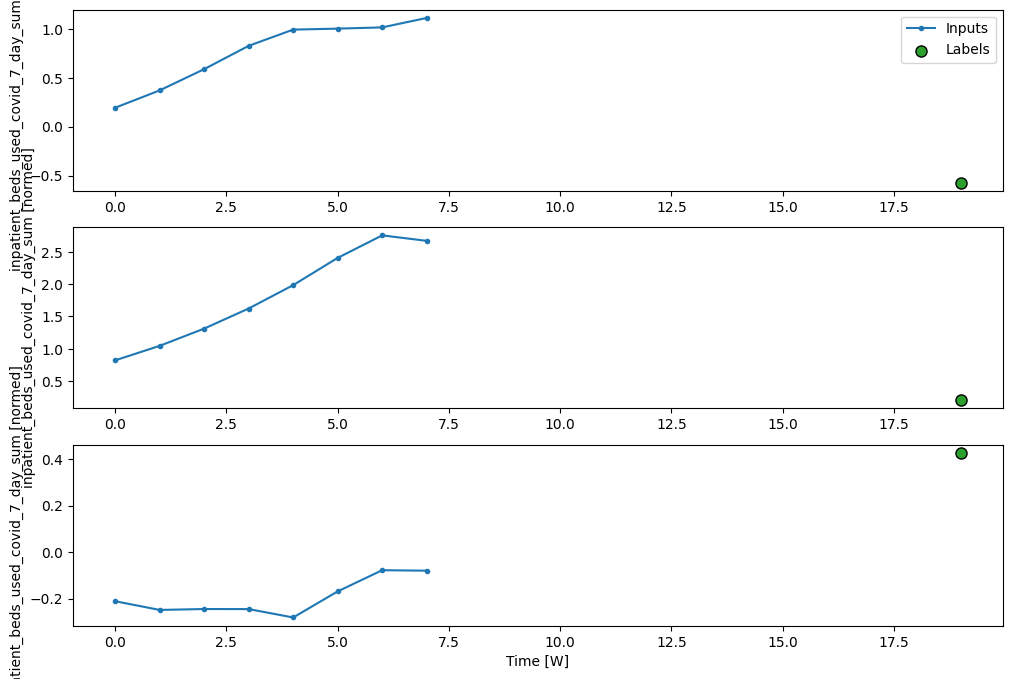

In [30]:
w1.plot_example = example_inputs, example_labels
w1.plot()

# Models

## Baseline

In [31]:
for example_inputs, example_labels in w1.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 8, 17)
Labels shape (batch, time, features): (32, 1, 1)


In [32]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

baseline = Baseline(label_index=w1.label_columns_indices['inpatient_beds_used_covid_7_day_sum'])
baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

baseline = Baseline(label_index=w1.column_indices['inpatient_beds_used_covid_7_day_sum'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance['Baseline'] = baseline.evaluate(w1.val)
performance['Baseline'] = baseline.evaluate(w1.test, verbose=0)

26/26 [==============================] - 0s 1ms/step - loss: 0.4044 - mean_absolute_error: 0.4134


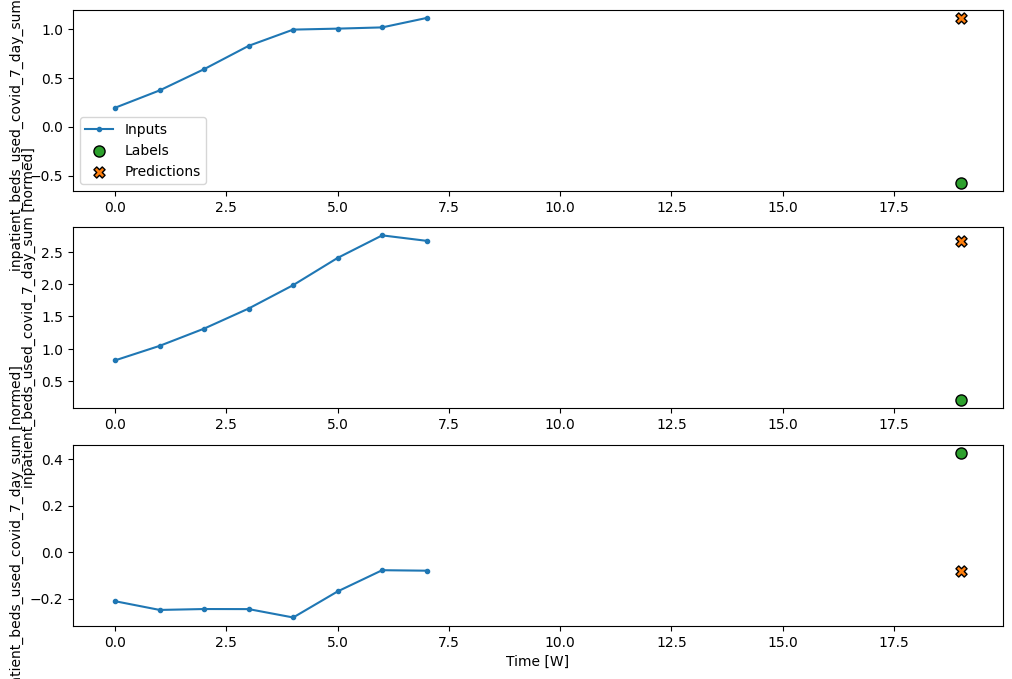

In [33]:
w1.plot(baseline)

## Linear

In [34]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

history = compile_and_fit(linear, w1)

val_performance['Linear'] = linear.evaluate(w1.val)
performance['Linear'] = linear.evaluate(w1.test, verbose=0)

Epoch 1/20
187/187 [==============================] - 1s 2ms/step - loss: 86737.9141 - mean_absolute_error: 153.4198 - val_loss: 62039.3164 - val_mean_absolute_error: 154.9105
Epoch 2/20
187/187 [==============================] - 0s 1ms/step - loss: 35307.9922 - mean_absolute_error: 98.4445 - val_loss: 23042.4121 - val_mean_absolute_error: 95.4375
Epoch 3/20
187/187 [==============================] - 0s 1ms/step - loss: 11931.3848 - mean_absolute_error: 58.0807 - val_loss: 7007.8052 - val_mean_absolute_error: 53.7856
Epoch 4/20
187/187 [==============================] - 0s 1ms/step - loss: 3209.9648 - mean_absolute_error: 31.1152 - val_loss: 1749.9895 - val_mean_absolute_error: 28.1100
Epoch 5/20
187/187 [==============================] - 0s 1ms/step - loss: 682.6361 - mean_absolute_error: 15.6502 - val_loss: 369.2351 - val_mean_absolute_error: 14.1287
Epoch 6/20
187/187 [==============================] - 0s 1ms/step - loss: 127.3641 - mean_absolute_error: 8.0120 - val_loss: 84.8186 - 

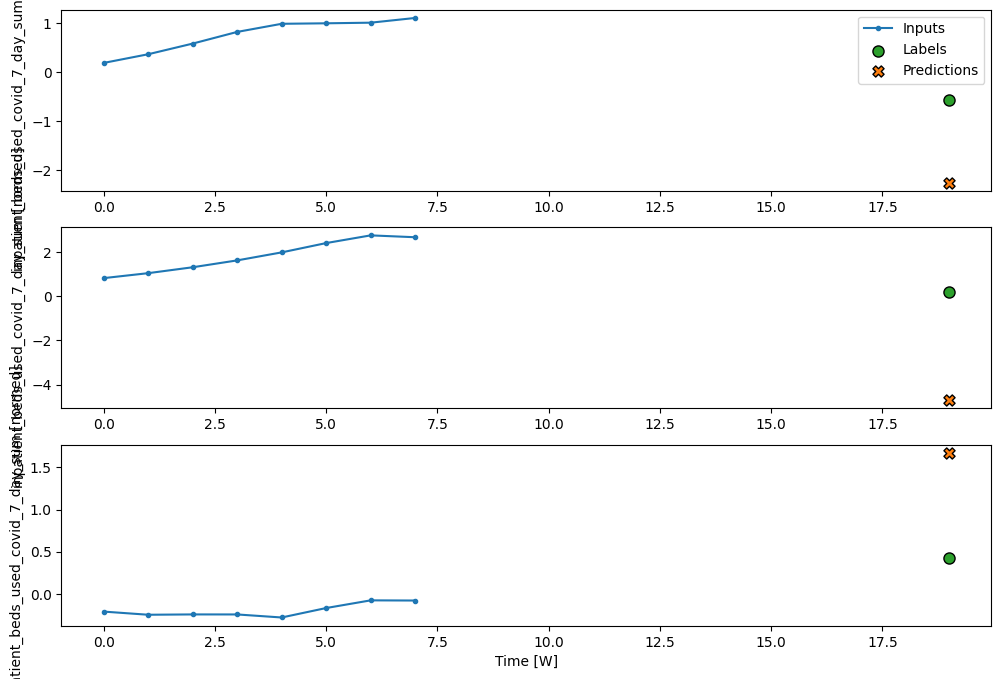

In [35]:
w1.plot(linear)

## Multi Layer Perceptron

In [36]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, w1)

val_performance['Dense'] = dense.evaluate(w1.val)
performance['Dense'] = dense.evaluate(w1.test, verbose=0)

Epoch 1/20
187/187 [==============================] - 1s 3ms/step - loss: 6.7629 - mean_absolute_error: 0.8720 - val_loss: 4.5336 - val_mean_absolute_error: 1.3306
Epoch 2/20
187/187 [==============================] - 1s 3ms/step - loss: 4.8886 - mean_absolute_error: 0.9945 - val_loss: 1.5247 - val_mean_absolute_error: 0.8288
Epoch 3/20
187/187 [==============================] - 0s 2ms/step - loss: 32.5870 - mean_absolute_error: 2.4616 - val_loss: 0.6290 - val_mean_absolute_error: 0.5258
Epoch 4/20
187/187 [==============================] - 1s 3ms/step - loss: 1.7264 - mean_absolute_error: 0.6050 - val_loss: 0.2839 - val_mean_absolute_error: 0.3360
Epoch 5/20
187/187 [==============================] - 0s 2ms/step - loss: 0.8291 - mean_absolute_error: 0.4733 - val_loss: 0.6266 - val_mean_absolute_error: 0.5240
Epoch 6/20
26/26 [==============================] - 0s 1ms/step - loss: 0.2961 - mean_absolute_error: 0.3463


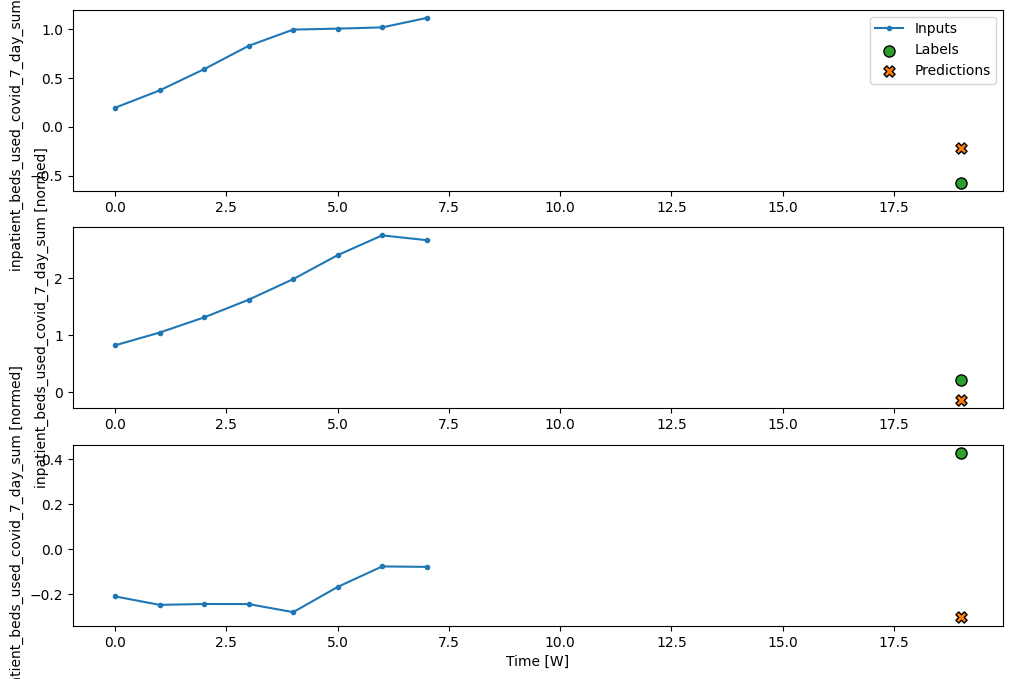

In [37]:
w1.plot(dense)

## CNN

In [38]:
wide_window = WindowGenerator(input_width=8, label_width=8, shift=12, train_df=train_df_num, test_df=test_df_num, val_df=val_df_num, label_columns=['inpatient_beds_used_covid_7_day_sum'])

In [39]:
CONV_WIDTH = 8
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=12,
    label_columns=['inpatient_beds_used_covid_7_day_sum'], train_df=train_df_num, test_df=test_df_num, val_df=val_df_num)

conv_window

Total window size: 20
Input indices: [0 1 2 3 4 5 6 7]
Label indices: [19]
Label column name(s): ['inpatient_beds_used_covid_7_day_sum']

In [40]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [41]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

26/26 [==============================] - 0s 1ms/step - loss: 5.9568 - mean_absolute_error: 1.4283


In [42]:
conv_window

Total window size: 20
Input indices: [0 1 2 3 4 5 6 7]
Label indices: [19]
Label column name(s): ['inpatient_beds_used_covid_7_day_sum']

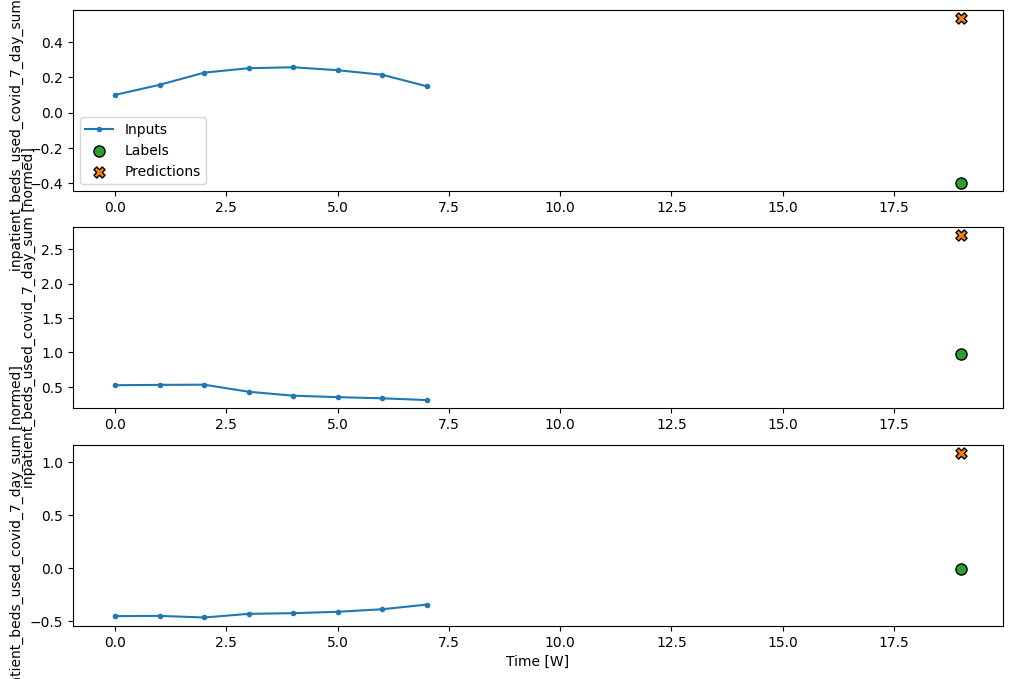

In [43]:
conv_window.plot(conv_model)

In [44]:
conv_model_wide = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=8),
])
history = compile_and_fit(conv_model_wide, wide_window)

Epoch 1/20
187/187 [==============================] - 1s 3ms/step - loss: 1312.7852 - mean_absolute_error: 9.0287 - val_loss: 111.4355 - val_mean_absolute_error: 4.9871
Epoch 2/20
187/187 [==============================] - 0s 2ms/step - loss: 37.9744 - mean_absolute_error: 2.6467 - val_loss: 47.0318 - val_mean_absolute_error: 3.4195
Epoch 3/20
187/187 [==============================] - 0s 2ms/step - loss: 20.0609 - mean_absolute_error: 1.9308 - val_loss: 28.2004 - val_mean_absolute_error: 2.7863
Epoch 4/20
187/187 [==============================] - 0s 2ms/step - loss: 12.3670 - mean_absolute_error: 1.5759 - val_loss: 15.6648 - val_mean_absolute_error: 1.9494
Epoch 5/20
187/187 [==============================] - 0s 2ms/step - loss: 8.5602 - mean_absolute_error: 1.3414 - val_loss: 11.7429 - val_mean_absolute_error: 1.6534
Epoch 6/20
187/187 [==============================] - 0s 2ms/step - loss: 6.5538 - mean_absolute_error: 1.1948 - val_loss: 8.8911 - val_mean_absolute_error: 1.4325
Epoc

ValueError: x and y must be the same size

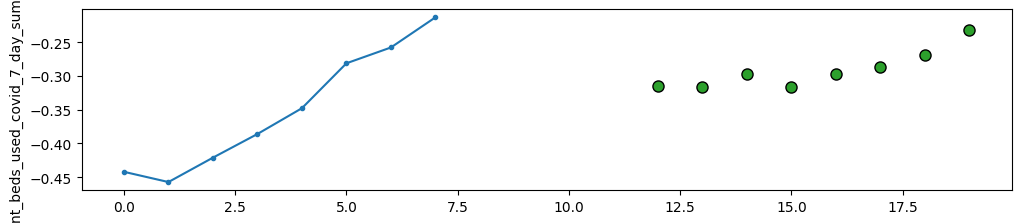

In [45]:
wide_window.plot(conv_model_wide)

## RNN (LSTM)

In [47]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [48]:
history = compile_and_fit(lstm_model, w1)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( w1.val)
performance['LSTM'] = lstm_model.evaluate( w1.test, verbose=0)

print()

26/26 [==============================] - 0s 3ms/step - loss: 0.3519 - mean_absolute_error: 0.4268



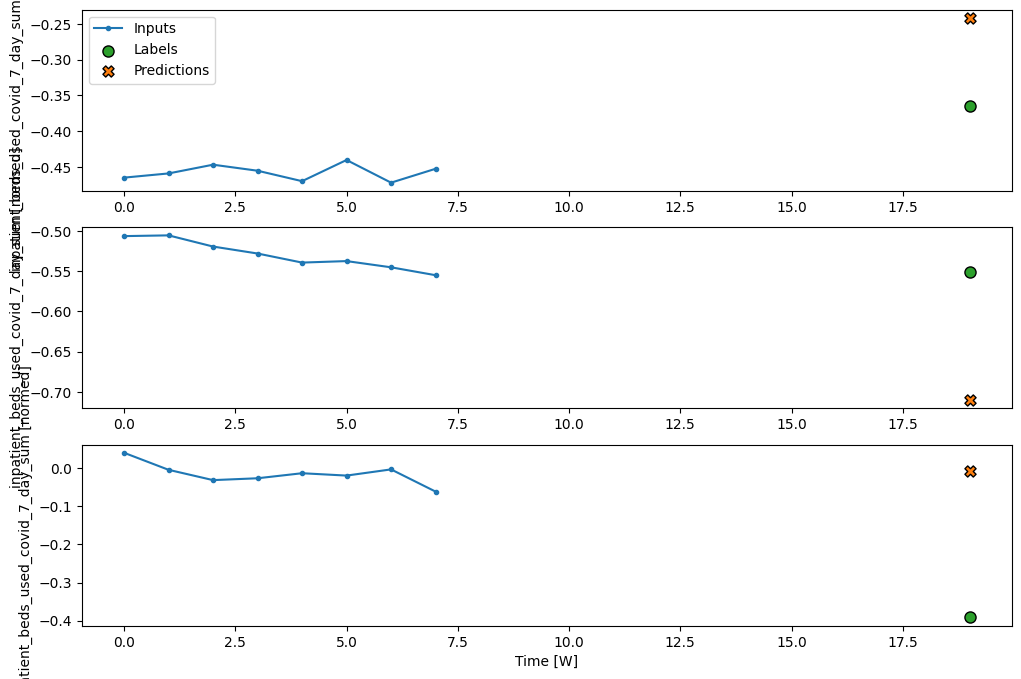

In [ ]:
w1.plot(lstm_model)

In [49]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM_w'] = lstm_model.evaluate( wide_window.val)
performance['LSTM_w'] = lstm_model.evaluate( wide_window.test, verbose=0)

26/26 [==============================] - 0s 3ms/step - loss: 0.4092 - mean_absolute_error: 0.4782


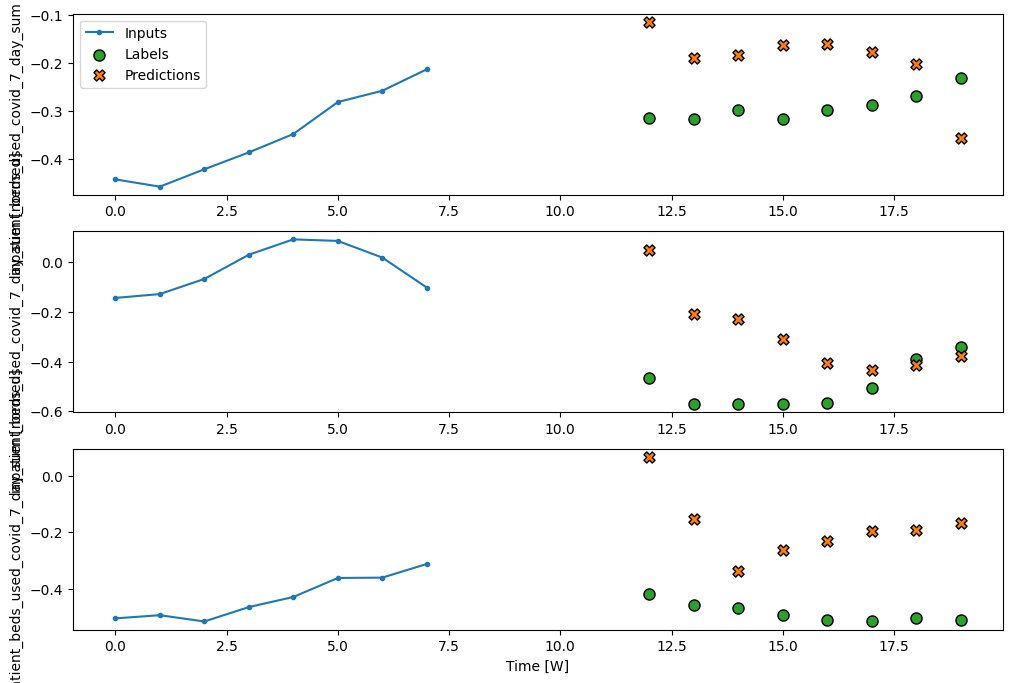

In [50]:
wide_window.plot(lstm_model)

## ResNet

In [ ]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each time step is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

In [ ]:
"""
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        1,
        # The predicted deltas should start small.
        # Therefore, initialize the output layer with zeros.
        kernel_initializer=tf.initializers.zeros())
]))

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)
"""

"\nresidual_lstm = ResidualWrapper(\n    tf.keras.Sequential([\n    tf.keras.layers.LSTM(32, return_sequences=True),\n    tf.keras.layers.Dense(\n        1,\n        # The predicted deltas should start small.\n        # Therefore, initialize the output layer with zeros.\n        kernel_initializer=tf.initializers.zeros())\n]))\n\nhistory = compile_and_fit(residual_lstm, wide_window)\n\nIPython.display.clear_output()\nval_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)\nperformance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)\n"